=== CLOTHING UPLOAD FEATURE ===
=== CLOTHING CATEGORIZATION ===
=== MIX & MATCH SUGGESTIONS ===
=== DEMONSTRATION ===
ℹ No items in wardrobe to build index
✓ Sample images created
Uploading sample items to wardrobe...


/tmp/ipython-input-3250730129.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.wardrobe_db = pd.concat([self.wardrobe_db, pd.DataFrame([item_data])], ignore_index=True)


✓ Metadata saved to data/wardrobe/metadata/item_1.json
✓ Item uploaded successfully! Item ID: 1
✓ Metadata saved to data/wardrobe/metadata/item_2.json
✓ Item uploaded successfully! Item ID: 2
✓ Metadata saved to data/wardrobe/metadata/item_3.json
✓ Item uploaded successfully! Item ID: 3
✓ Metadata saved to data/wardrobe/metadata/item_4.json
✓ Item uploaded successfully! Item ID: 4
✓ Metadata saved to data/wardrobe/metadata/item_5.json
✓ Item uploaded successfully! Item ID: 5
✓ Database saved to data/wardrobe/wardrobe_database.csv

User 1's Wardrobe:
  item_id category  color   style
0       1    pants    red  casual
1       2    shoes   blue  casual
2       3    shoes  black  casual
3       4    shoes  white  casual
4       5    pants  green  casual

Generating outfit suggestions for user 1...

Outfit 1 (Compatibility: 0.670):
  bottom: red pants
  shoes: blue shoes

Outfit 2 (Compatibility: 0.325):
  bottom: red pants
  shoes: white shoes

Outfit 3 (Compatibility: 0.325):
  bottom: re

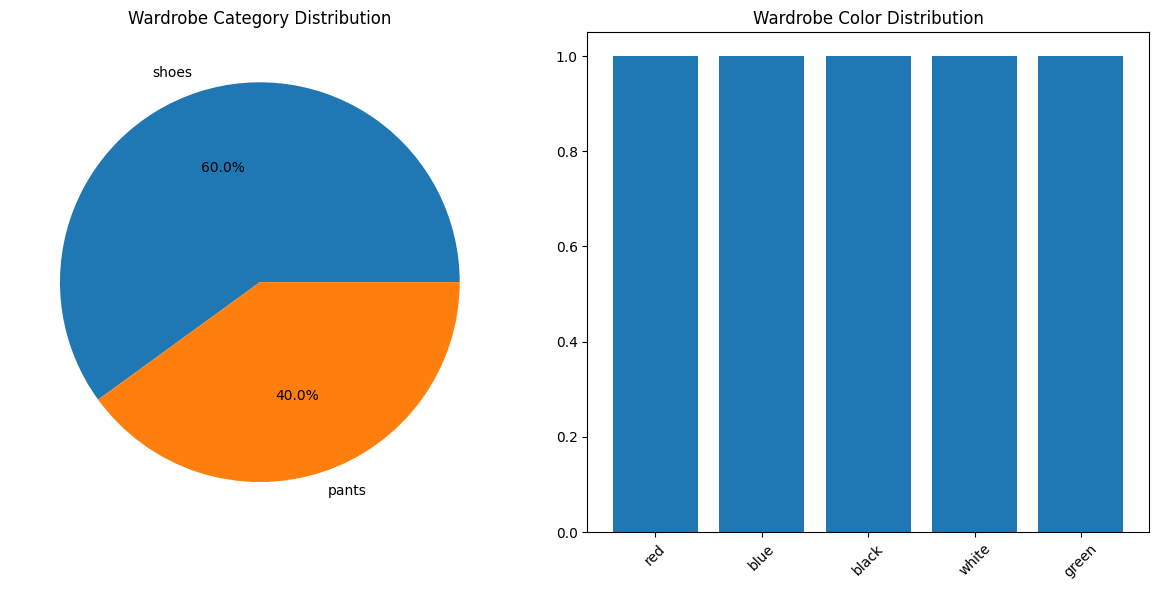

=== WARDROBE MANAGEMENT SYSTEM COMPLETE ===


In [ ]:

# Wardrobe Management System (Fixed)


# Install required packages
%pip install pandas numpy scikit-learn matplotlib seaborn torch torchvision pillow
%pip install faiss-cpu
%pip install opencv-python

# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import json
from datetime import datetime

# Create directory structure
os.makedirs('data/wardrobe', exist_ok=True)
os.makedirs('data/wardrobe/images', exist_ok=True)
os.makedirs('data/wardrobe/metadata', exist_ok=True)
os.makedirs('models', exist_ok=True)

# 1. Clothing Upload Feature
print("=== CLOTHING UPLOAD FEATURE ===")

class WardrobeManager:
    def __init__(self, classifier):
        self.wardrobe_db = pd.DataFrame(columns=[
            'item_id', 'user_id', 'image_path', 'category', 'color',
            'style', 'season', 'upload_date', 'features'
        ])
        self.next_item_id = 1
        self.classifier = classifier

    def upload_clothing_item(self, user_id, image_path, metadata=None):
        """Upload a clothing item to user's wardrobe"""
        try:
            # Process and save image
            img = Image.open(image_path)
            img = img.convert('RGB')

            # Generate unique filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"user_{user_id}_{timestamp}_{self.next_item_id}.jpg"
            save_path = f"data/wardrobe/images/{filename}"
            img.save(save_path)

            # Categorize clothing using the classifier
            category = self.classifier.categorize_clothing(img)

            # Extract features using the classifier
            features = self.classifier.extract_features(img)

            # Create item record
            item_data = {
                'item_id': self.next_item_id,
                'user_id': user_id,
                'image_path': save_path,
                'category': category,
                'color': metadata.get('color', 'unknown') if metadata else 'unknown',
                'style': metadata.get('style', 'casual') if metadata else 'casual',
                'season': metadata.get('season', 'all') if metadata else 'all',
                'upload_date': datetime.now(),
                'features': features.tolist() if hasattr(features, 'tolist') else features
            }

            # Add to database
            self.wardrobe_db = pd.concat([self.wardrobe_db, pd.DataFrame([item_data])], ignore_index=True)

            # Save metadata
            self.save_metadata(item_data)

            self.next_item_id += 1
            print(f"✓ Item uploaded successfully! Item ID: {item_data['item_id']}")
            return item_data

        except Exception as e:
            print(f"✗ Error uploading item: {e}")
            return None

    def save_metadata(self, item_data):
        """Save item metadata to JSON file"""
        metadata_path = f"data/wardrobe/metadata/item_{item_data['item_id']}.json"
        with open(metadata_path, 'w') as f:
            json.dump(item_data, f, default=str, indent=2)
        print(f"✓ Metadata saved to {metadata_path}")

    def get_user_wardrobe(self, user_id):
        """Get all items in user's wardrobe"""
        return self.wardrobe_db[self.wardrobe_db['user_id'] == user_id]

    def save_database(self):
        """Save wardrobe database to CSV"""
        self.wardrobe_db.to_csv('data/wardrobe/wardrobe_database.csv', index=False)
        print("✓ Database saved to data/wardrobe/wardrobe_database.csv")

    def load_database(self):
        """Load wardrobe database from CSV"""
        if os.path.exists('data/wardrobe/wardrobe_database.csv'):
            self.wardrobe_db = pd.read_csv('data/wardrobe/wardrobe_database.csv')
            if not self.wardrobe_db.empty:
                self.next_item_id = self.wardrobe_db['item_id'].max() + 1
            print("✓ Database loaded successfully")
        else:
            print("ℹ No existing database found")

# 2. Clothing Categorization - FIXED VERSION
print("=== CLOTHING CATEGORIZATION ===")

class ClothingClassifier:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.load_pretrained_model()
        self.transform = self.get_transform()
        self.category_map = {
            0: 't-shirt', 1: 'pants', 2: 'dress', 3: 'shirt',
            4: 'shoes', 5: 'jacket', 6: 'skirt', 7: 'accessory'
        }

    def load_pretrained_model(self):
        """Load a pre-trained ResNet model for clothing classification"""
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 8)  # 8 clothing categories

        # Set model to evaluation mode
        model.eval()

        return model.to(self.device)

    def get_transform(self):
        """Get image transformation for model input"""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def categorize_clothing(self, image):
        """Categorize clothing item using CNN"""
        try:
            # Preprocess image
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)

            # Predict category
            with torch.no_grad():
                outputs = self.model(image_tensor)
                _, predicted = torch.max(outputs, 1)
                category_idx = predicted.item()

            return self.category_map.get(category_idx, 'unknown')

        except Exception as e:
            print(f"Error in categorization: {e}")
            return 'unknown'

    def extract_features(self, image):
        """Extract visual features from clothing image"""
        try:
            # Use the model to extract features
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)

            # Extract features from the layer before the final classification layer
            with torch.no_grad():
                features = self.model(image_tensor)

            # Detach from computation graph and convert to numpy
            features = features.cpu().detach().numpy().flatten()

            return features

        except Exception as e:
            print(f"Error extracting features: {e}")
            return np.random.rand(512)  # Return random features for demo

# 3. Mix & Match Suggestions
print("=== MIX & MATCH SUGGESTIONS ===")

class OutfitRecommender:
    def __init__(self, wardrobe_manager):
        self.wardrobe_manager = wardrobe_manager
        self.index = None
        self.build_index()

    def build_index(self):
        """Build FAISS index for similarity search"""
        if not self.wardrobe_manager.wardrobe_db.empty:
            # Convert features from string to numpy array if needed
            features_list = []
            for features_str in self.wardrobe_manager.wardrobe_db['features']:
                if isinstance(features_str, str):
                    # Convert string representation to numpy array
                    features = np.fromstring(features_str.strip('[]'), sep=' ')
                else:
                    features = np.array(features_str)
                features_list.append(features)

            features = np.array(features_list)
            self.index = faiss.IndexFlatL2(features.shape[1])
            self.index.add(features.astype(np.float32))
            print("✓ FAISS index built successfully")
        else:
            print("ℹ No items in wardrobe to build index")

    def find_similar_items(self, query_features, k=5):
        """Find similar items using FAISS"""
        if self.index is None:
            return [], []

        distances, indices = self.index.search(
            query_features.astype(np.float32).reshape(1, -1), k
        )
        return indices[0], distances[0]

    def suggest_outfits(self, user_id, n_outfits=5):
        """Suggest complete outfits from user's wardrobe"""
        user_wardrobe = self.wardrobe_manager.get_user_wardrobe(user_id)

        if user_wardrobe.empty:
            print("No items in wardrobe")
            return []

        # Group items by category
        categories = {
            'tops': user_wardrobe[user_wardrobe['category'].isin(['t-shirt', 'shirt', 'dress'])],
            'bottoms': user_wardrobe[user_wardrobe['category'].isin(['pants', 'skirt'])],
            'shoes': user_wardrobe[user_wardrobe['category'] == 'shoes'],
            'outerwear': user_wardrobe[user_wardrobe['category'].isin(['jacket'])],
            'accessories': user_wardrobe[user_wardrobe['category'] == 'accessory']
        }

        outfits = []

        for _ in range(n_outfits):
            outfit = {}

            # Try to include one item from each category
            if not categories['tops'].empty:
                top = categories['tops'].sample(1).iloc[0]
                outfit['top'] = top

            if not categories['bottoms'].empty:
                bottom = categories['bottoms'].sample(1).iloc[0]
                outfit['bottom'] = bottom

            if not categories['shoes'].empty:
                shoes = categories['shoes'].sample(1).iloc[0]
                outfit['shoes'] = shoes

            if not categories['outerwear'].empty and np.random.random() > 0.5:
                outerwear = categories['outerwear'].sample(1).iloc[0]
                outfit['outerwear'] = outerwear

            if not categories['accessories'].empty and np.random.random() > 0.7:
                accessory = categories['accessories'].sample(1).iloc[0]
                outfit['accessory'] = accessory

            if outfit:  # Only add if we have at least one item
                # Calculate outfit compatibility score
                outfit['compatibility_score'] = self.calculate_compatibility(outfit)
                outfits.append(outfit)

        # Sort by compatibility score
        outfits.sort(key=lambda x: x['compatibility_score'], reverse=True)
        return outfits

    def calculate_compatibility(self, outfit):
        """Calculate how well items in an outfit go together"""
        score = 0

        # Extract features of all items
        item_features = []
        for key, item in outfit.items():
            if key != 'compatibility_score':
                if isinstance(item['features'], str):
                    features = np.fromstring(item['features'].strip('[]'), sep=' ')
                else:
                    features = np.array(item['features'])
                item_features.append(features)

        if len(item_features) < 2:
            return 0.5  # Neutral score for single items

        # Calculate average cosine similarity between all pairs
        similarities = []
        for i in range(len(item_features)):
            for j in range(i + 1, len(item_features)):
                sim = cosine_similarity(
                    item_features[i].reshape(1, -1),
                    item_features[j].reshape(1, -1)
                )[0][0]
                similarities.append(sim)

        if similarities:
            score = np.mean(similarities)

        return max(0, min(1, score))  # Ensure score is between 0-1

    def recommend_similar_items(self, user_id, item_id, k=3):
        """Recommend items similar to a specific item"""
        user_wardrobe = self.wardrobe_manager.get_user_wardrobe(user_id)

        if user_wardrobe.empty:
            return []

        # Find the target item
        target_item = user_wardrobe[user_wardrobe['item_id'] == item_id]
        if target_item.empty:
            return []

        # Get features of target item
        if isinstance(target_item['features'].iloc[0], str):
            target_features = np.fromstring(target_item['features'].iloc[0].strip('[]'), sep=' ')
        else:
            target_features = np.array(target_item['features'].iloc[0])

        # Find similar items
        similar_indices, distances = self.find_similar_items(target_features, k + 1)

        # Exclude the target item itself
        recommendations = []
        for idx, dist in zip(similar_indices, distances):
            if idx < len(user_wardrobe):
                item = user_wardrobe.iloc[idx]
                if item['item_id'] != item_id:  # Don't recommend the same item
                    recommendations.append((item, dist))

        return recommendations[:k]

# Demo and Testing
print("=== DEMONSTRATION ===")

# Create sample images for demonstration
def create_sample_images():
    """Create sample clothing images for demonstration"""
    os.makedirs('sample_images', exist_ok=True)

    # Create sample images with different colors and categories
    test_items = [
        {'color': 'red', 'category': 't-shirt'},
        {'color': 'blue', 'category': 'shirt'},
        {'color': 'black', 'category': 'pants'},
        {'color': 'white', 'category': 'shoes'},
        {'color': 'green', 'category': 'dress'}
    ]

    image_paths = []

    for i, item in enumerate(test_items):
        # Create a simple colored image
        img = np.zeros((200, 200, 3), dtype=np.uint8)

        # Set color based on item
        if item['color'] == 'red':
            img[:, :] = [255, 0, 0]
        elif item['color'] == 'blue':
            img[:, :] = [0, 0, 255]
        elif item['color'] == 'green':
            img[:, :] = [0, 255, 0]
        elif item['color'] == 'black':
            img[:, :] = [0, 0, 0]
        else:  # white
            img[:, :] = [255, 255, 255]

        # Add text label
        cv2.putText(img, f"{item['color']} {item['category']}", (10, 100),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Save image
        filename = f"sample_images/{item['color']}_{item['category']}_{i}.jpg"
        cv2.imwrite(filename, img)
        image_paths.append(filename)

    print("✓ Sample images created")
    return image_paths

# Initialize components in the correct order
classifier = ClothingClassifier()
wardrobe_manager = WardrobeManager(classifier)
recommender = OutfitRecommender(wardrobe_manager)

# Create sample images
sample_images = create_sample_images()

# Upload sample items to wardrobe
user_id = 1
print("Uploading sample items to wardrobe...")
for i, img_path in enumerate(sample_images):
    # Extract color and category from filename for metadata
    filename = img_path.split('/')[-1]
    color = filename.split('_')[0]
    category = filename.split('_')[1]

    metadata = {
        'color': color,
        'category': category,  # Add category to metadata
        'style': 'casual',
        'season': 'all'
    }
    wardrobe_manager.upload_clothing_item(user_id, img_path, metadata)

# Save the database
wardrobe_manager.save_database()

# Display user's wardrobe
user_wardrobe = wardrobe_manager.get_user_wardrobe(user_id)
print(f"\nUser {user_id}'s Wardrobe:")
print(user_wardrobe[['item_id', 'category', 'color', 'style']])

# Generate outfit suggestions
print(f"\nGenerating outfit suggestions for user {user_id}...")
outfits = recommender.suggest_outfits(user_id, n_outfits=3)

for i, outfit in enumerate(outfits):
    print(f"\nOutfit {i+1} (Compatibility: {outfit['compatibility_score']:.3f}):")
    for item_type, item in outfit.items():
        if item_type != 'compatibility_score':
            print(f"  {item_type}: {item['color']} {item['category']}")

# Test similar item recommendations
if not user_wardrobe.empty:
    target_item_id = user_wardrobe.iloc[0]['item_id']
    print(f"\nRecommendations similar to Item {target_item_id}:")
    similar_items = recommender.recommend_similar_items(user_id, target_item_id)

    for item, distance in similar_items:
        print(f"  Similar item: {item['color']} {item['category']} (Distance: {distance:.3f})")

# Visualization
print("\n=== VISUALIZATION ===")

def visualize_wardrobe(user_wardrobe):
    """Visualize the user's wardrobe"""
    if user_wardrobe.empty:
        print("No items to visualize")
        return

    plt.figure(figsize=(12, 6))

    # Category distribution
    plt.subplot(1, 2, 1)
    category_counts = user_wardrobe['category'].value_counts()
    plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    plt.title('Wardrobe Category Distribution')

    # Color distribution
    plt.subplot(1, 2, 2)
    color_counts = user_wardrobe['color'].value_counts()
    plt.bar(color_counts.index, color_counts.values)
    plt.title('Wardrobe Color Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Visualize the wardrobe
visualize_wardrobe(user_wardrobe)

print("=== WARDROBE MANAGEMENT SYSTEM COMPLETE ===")